In [4]:
import torch
from torch import nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F

# Import some useful packages for this homework
import numpy as np
import pandas as pd
import os
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset # "ConcatDataset" and "Subset" are possibly useful
from torchvision.datasets import DatasetFolder, VisionDataset
from torchsummary import summary
from tqdm.auto import tqdm
import random

# !nvidia-smi # list your current GPU

/home/yuehpo/miniconda3/envs/hw13/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5x5 image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, int(x.nelement() / x.shape[0]))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = LeNet().to(device=device)

Let's say now you want to prune all the parameters named with `weight` in all the `nn.Conv2d` layers in the `model`, with pruning ratio **0.2**. Then please refer to the code below to achieve this.

In [6]:
ratio = 0.2 # specify the pruning ratio
for name, module in model.named_modules():
    if isinstance(module, torch.nn.Conv2d): # if the nn.module is torch.nn.Conv2d
        prune.l1_unstructured(module, name='weight', amount=ratio) # use 'prune' method provided by 'torch.nn.utils.prune' to prune the weight parameters in the nn.Conv2d layers
# Next, you just have to generize the above code to different ratio and test the accuracy on the validation set of food11-hw13.

In [35]:
cfg = {
    'dataset_root': './Food-11',
    'save_dir': './outputs',
    'exp_name': "medium_baseline",
    'batch_size': 2048,
    'lr': 3e-4,
    'seed': 20220013,
    'loss_fn_type': 'KD', # simple baseline: CE, medium baseline: KD. See the Knowledge_Distillation part for more information.
    'weight_decay': 1e-5,
    'grad_norm_max': 10,
    'n_epochs': 600, # train more steps to pass the medium baseline.
    'patience': 300,
}

In [36]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# define training/testing transforms
test_tfm = transforms.Compose([
    # It is not encouraged to modify this part if you are using the provided teacher model. This transform is stardard and good enough for testing.
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

train_tfm = transforms.Compose([
    # add some useful transform or augmentation here, according to your experience in HW3.
    transforms.Resize(256),  # You can change this
    transforms.CenterCrop(224), # You can change this, but be aware of that the given teacher model's input size is 224.
    # The training input size of the provided teacher model is (3, 224, 224).
    # Thus, Input size other then 224 might hurt the performance. please be careful.
    
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),

    transforms.ToTensor(),
    normalize,
])

In [37]:
class FoodDataset(Dataset):
    def __init__(self, path, tfm=test_tfm, files = None):
        super().__init__()
        self.path = path
        self.files = sorted([os.path.join(path,x) for x in os.listdir(path) if x.endswith(".jpg")])
        if files != None:
            self.files = files
        print(f"One {path} sample",self.files[0])
        self.transform = tfm

    def __len__(self):
        return len(self.files)

    def __getitem__(self,idx):
        fname = self.files[idx]
        im = Image.open(fname)
        im = self.transform(im)
        try:
            label = int(fname.split("/")[-1].split("_")[0])
        except:
            label = -1 # test has no label
        return im,label

In [38]:
# create dataloader for evaluation
eval_set = FoodDataset(os.path.join(cfg['dataset_root'], "validation"), tfm=test_tfm)
eval_loader = DataLoader(eval_set, batch_size=cfg['batch_size'], shuffle=False, num_workers=0, pin_memory=True)

One ./Food-11/validation sample ./Food-11/validation/0_0.jpg


In [39]:
# Load provided teacher model (model architecture: resnet18, num_classes=11, test-acc ~= 89.9%)
teacher_model_ori = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False, num_classes=11)
# load state dict
teacher_ckpt_path = os.path.join(cfg['dataset_root'], "resnet18_teacher.ckpt")
teacher_model_ori.load_state_dict(torch.load(teacher_ckpt_path, map_location='cpu'))

Using cache found in /home/yuehpo/.cache/torch/hub/pytorch_vision_v0.10.0
/home/yuehpo/miniconda3/envs/hw13/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yuehpo/miniconda3/envs/hw13/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

Pruning ratio: 0.0


100%|██████████| 3/3 [00:11<00:00,  3.84s/it]


Pruning ratio: 0.0, Accuracy: 0.9501353790613718
Pruning ratio: 0.05


100%|██████████| 3/3 [00:11<00:00,  3.87s/it]


Pruning ratio: 0.05, Accuracy: 0.9492328519855595
Pruning ratio: 0.1


100%|██████████| 3/3 [00:11<00:00,  3.86s/it]


Pruning ratio: 0.1, Accuracy: 0.9490072202166066
Pruning ratio: 0.15000000000000002


100%|██████████| 3/3 [00:11<00:00,  3.88s/it]


Pruning ratio: 0.15000000000000002, Accuracy: 0.9490072202166066
Pruning ratio: 0.2


100%|██████████| 3/3 [00:12<00:00,  4.24s/it]


Pruning ratio: 0.2, Accuracy: 0.9447202166064982
Pruning ratio: 0.25


100%|██████████| 3/3 [00:12<00:00,  4.06s/it]


Pruning ratio: 0.25, Accuracy: 0.9447202166064982
Pruning ratio: 0.30000000000000004


100%|██████████| 3/3 [00:12<00:00,  4.07s/it]


Pruning ratio: 0.30000000000000004, Accuracy: 0.9273465703971119
Pruning ratio: 0.35000000000000003


100%|██████████| 3/3 [00:12<00:00,  4.09s/it]


Pruning ratio: 0.35000000000000003, Accuracy: 0.9050090252707581
Pruning ratio: 0.4


100%|██████████| 3/3 [00:12<00:00,  4.07s/it]


Pruning ratio: 0.4, Accuracy: 0.8856046931407943
Pruning ratio: 0.45


100%|██████████| 3/3 [00:12<00:00,  4.08s/it]


Pruning ratio: 0.45, Accuracy: 0.7818140794223827
Pruning ratio: 0.5


100%|██████████| 3/3 [00:12<00:00,  4.07s/it]


Pruning ratio: 0.5, Accuracy: 0.5834837545126353
Pruning ratio: 0.55


100%|██████████| 3/3 [00:12<00:00,  4.08s/it]


Pruning ratio: 0.55, Accuracy: 0.3267148014440433
Pruning ratio: 0.6000000000000001


100%|██████████| 3/3 [00:12<00:00,  4.08s/it]


Pruning ratio: 0.6000000000000001, Accuracy: 0.1592960288808664
Pruning ratio: 0.65


100%|██████████| 3/3 [00:12<00:00,  4.10s/it]


Pruning ratio: 0.65, Accuracy: 0.11010830324909747
Pruning ratio: 0.7000000000000001


100%|██████████| 3/3 [00:12<00:00,  4.12s/it]


Pruning ratio: 0.7000000000000001, Accuracy: 0.1177797833935018
Pruning ratio: 0.75


100%|██████████| 3/3 [00:12<00:00,  4.09s/it]


Pruning ratio: 0.75, Accuracy: 0.10424187725631769
Pruning ratio: 0.8


100%|██████████| 3/3 [00:13<00:00,  4.34s/it]


Pruning ratio: 0.8, Accuracy: 0.10717509025270758
Pruning ratio: 0.8500000000000001


100%|██████████| 3/3 [00:12<00:00,  4.10s/it]


Pruning ratio: 0.8500000000000001, Accuracy: 0.10356498194945848
Pruning ratio: 0.9


100%|██████████| 3/3 [00:12<00:00,  4.08s/it]


Pruning ratio: 0.9, Accuracy: 0.09318592057761733
Pruning ratio: 0.9500000000000001


100%|██████████| 3/3 [00:12<00:00,  4.10s/it]

Pruning ratio: 0.9500000000000001, Accuracy: 0.0904783393501805


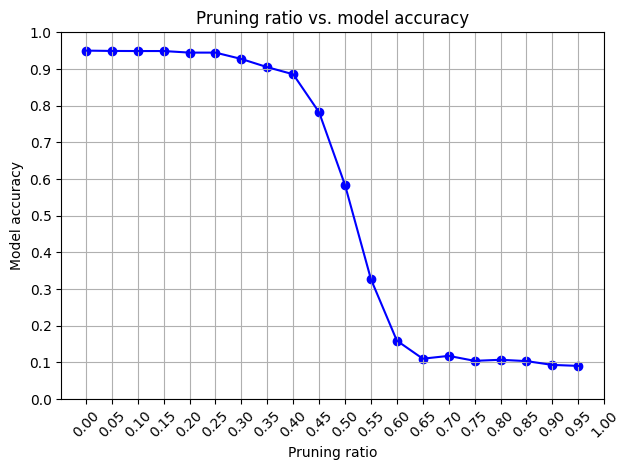

In [41]:
# prune the teacher model for different ratio: 0 to 1 with step size 0.05
# and evaluate the accuracy on the validation set of food11-hw13
# plot the model accuracy and the pruning ratio with matplotlib

import matplotlib.pyplot as plt
import copy
dots = []
for ratio in np.arange(0,1,0.05):
    print(f"Pruning ratio: {ratio}")
    
    # copy the teacher model from teacher_model_ori
    teacher_model = copy.deepcopy(teacher_model_ori)
    
    for name, module in teacher_model.named_modules():
        if isinstance(module, torch.nn.Conv2d): # if the nn.module is torch.nn.Conv2d
            prune.l1_unstructured(module, name='weight', amount=ratio) # use 'prune' method provided by 'torch.nn.utils.prune' to prune the weight parameters in the nn.Conv2d layers
    teacher_model.eval()
    teacher_model.to(device=device)
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y_gt in tqdm(eval_loader):
            x = x.to(device=device)
            y_gt = y_gt.to(device=device)
            y_pred = teacher_model(x)
            y_pred = torch.argmax(y_pred, dim=1)
            correct += (y_pred == y_gt).sum().item()
            total += len(y_gt)
    acc = correct / total
    print(f"Pruning ratio: {ratio}, Accuracy: {acc}")
    plt.scatter(ratio, acc, c='b', marker='o', label='teacher model')
    dots.append((ratio, acc))

# connect the scatter points with line
plt.plot([x[0] for x in dots], [x[1] for x in dots], c='b', label='teacher model')

plt.title("Pruning ratio vs. model accuracy")


# plot the grid with equally spaced ticks
plt.grid(True)
plt.xticks(np.arange(0, 1.05, 0.05))
plt.yticks(np.arange(0, 1.1, 0.1))

# lean the x ticks labels 45 degrees
plt.xticks(rotation=45)

plt.xlabel("Pruning ratio")
plt.ylabel("Model accuracy")
plt.tight_layout()
plt.savefig("pruning_ratio_vs_model_accuracy.png")
    